In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import percentile
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv("/content/drive/MyDrive/dataset 3/DateTime.csv")
df.shape


(28200, 22)

In [7]:
df.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

In [ ]:
df.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [29]:
track = df['tracking_id']
dat = df['datetime']
df.drop(['tracking_id'],axis=1,inplace=True)

In [9]:
df.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

In [30]:
df.drop(['turbine_status','wind_direction(°)','blade_length(m)'],axis=1,inplace=True)

In [31]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [32]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

In [ ]:
threshold = 0.9
df_corr = df.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
df = df[selected_columns]

IndexError: ignored

In [ ]:
X.isnull().sum()

datetime                            0
wind_speed(m/s)                   273
atmospheric_temperature(°C)      3450
shaft_temperature(°C)               2
blades_angle(°)                   216
gearbox_temperature(°C)             1
engine_temperature(°C)             12
motor_torque(N-m)                  24
generator_temperature(°C)          12
atmospheric_pressure(Pascal)     2707
area_temperature(°C)                0
windmill_body_temperature(°C)    2363
resistance(ohm)                     1
rotor_torque(N-m)                 572
cloud_level                       276
blade_breadth(m)                    0
windmill_height(m)                543
dtype: int64

In [33]:
X = pd.get_dummies(X)
for i in range(len(X.columns)):
  X[X.columns[i]] = X[X.columns[i]].fillna(X[X.columns[i]].mean())
X.head()  

,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),resistance(ohm),rotor_torque(N-m),blade_breadth(m),windmill_height(m),cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium
0,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,20.799761,2730.310605,42.084666,0.314065,24.281689,0,0,1
1,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,20.799761,1780.207200,107.888643,0.448494,27.262139,0,0,1
2,2019-09-14 14:03:20,95.484724,0.383727,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,1666.049900,-42.931459,0.302321,27.366127,0,0,1
3,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,1964.502895,42.744596,0.367140,24.287767,0,0,0
4,2019-05-04 03:13:20,10.722890,0.383727,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,1177.516152,13.387289,0.453374,27.971650,0,0,1


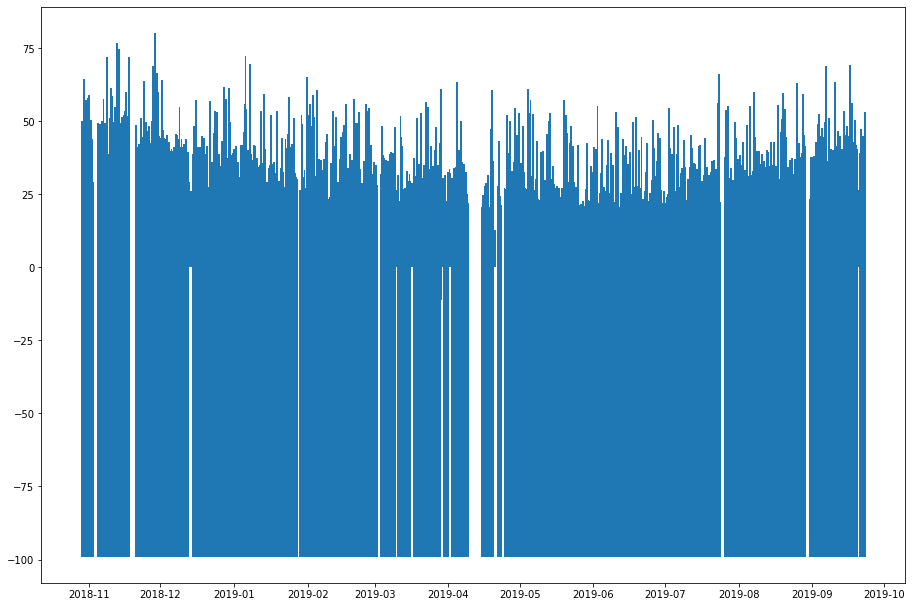

In [ ]:
fig = plt.figure()
ax = fig.add_axes([2,2,2,2])
ax.bar(df['datetime'],df['atmospheric_temperature(°C)'])
plt.show()

In [ ]:
sum = 0
for i in range(1,len(X.columns)):
  q25, q75 = percentile(X[X.columns[i]],25), percentile(X[X.columns[i]],75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  outliers = [x for x in X[X.columns[i]] if (x < lower) or (x > upper)]
  sum = sum+len(outliers)
sum  

54831

In [34]:
for i in range(1,len(X.columns)):
  q25, q75 = percentile(X[X.columns[i]],25), percentile(X[X.columns[i]],75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  median = float(X[X.columns[i]].median())
  X[X.columns[i]] = np.where((X[X.columns[i]] > upper) | (X[X.columns[i]] < lower), median,X[X.columns[i]])

In [ ]:
sum = 0
for i in range(1,len(X.columns)):
  q25, q75 = percentile(X[X.columns[i]],25), percentile(X[X.columns[i]],75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  outliers = [x for x in X[X.columns[i]] if (x < lower) or (x > upper)]
  sum = sum+len(outliers)
sum  

17667

In [ ]:
X.head()

,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),resistance(ohm),rotor_torque(N-m),blade_breadth(m),windmill_height(m),cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium
0,2019-08-04 14:33:20,94.820023,14.150602,41.723019,-0.903423,43.221521,42.523015,2563.124522,76.665560,103402.961872,26.897875,20.799761,1678.231923,42.084666,0.314065,24.281689,0.0,0.0,1.0
1,2018-11-05 10:13:20,93.256368,27.764785,43.685853,-0.527911,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,20.799761,1780.207200,31.549128,0.448494,27.262139,0.0,0.0,1.0
2,2019-09-14 14:03:20,95.484724,0.383727,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,1666.049900,31.549128,0.302321,27.366127,0.0,0.0,1.0
3,2018-12-25 15:33:20,93.256368,14.150602,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,1964.502895,42.744596,0.367140,24.287767,0.0,0.0,0.0
4,2019-05-04 03:13:20,10.722890,0.383727,41.981183,1.715696,43.221521,43.469852,781.695419,37.423065,114468.169007,34.572941,42.495191,1177.516152,13.387289,0.453374,27.971650,0.0,0.0,1.0


In [ ]:
fig = plt.figure()
ax = fig.add_axes([2,2,2,2])
ax.bar(X['datetime'],X['atmospheric_temperature(°C)'])
plt.show()

In [ ]:
X_corr = X.corr()
X_corr.drop(['cloud_level_Extremely Low','cloud_level_Low','cloud_level_Medium'],axis=1,inplace=True)
X_corr.drop(['cloud_level_Extremely Low','cloud_level_Low','cloud_level_Medium'],axis=0,inplace=True)
sns.heatmap(X_corr)

In [35]:
X.drop(['datetime'],axis=1,inplace=True)

In [36]:
Y.fillna(Y.mean(),inplace=True)
Y.head()

0     6.766521
1     5.966275
2     2.874342
3    14.851089
4     3.519074
Name: windmill_generated_power(kW/h), dtype: float64

In [37]:
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y,test_size=0.3,random_state=0)
X_train.head()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),resistance(ohm),rotor_torque(N-m),blade_breadth(m),windmill_height(m),cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium
24945,97.272684,32.007345,42.613104,0.078907,41.854125,41.866622,2128.899487,70.601318,18753.031517,36.583199,20.799761,1707.232502,81.354389,0.450207,25.790728,0.0,0.0,1.0
6427,94.413919,23.406481,43.265803,-1.277909,43.221521,46.329418,2327.886937,74.541788,17064.857821,26.112462,43.855310,1806.111422,39.562852,0.489403,25.887052,0.0,1.0,0.0
3517,69.037071,24.858446,43.685853,-0.647725,46.677880,45.940122,2348.049054,79.238049,18753.031517,43.233737,47.354694,1753.275598,31.549128,0.468701,27.874443,0.0,0.0,1.0
7508,21.153605,14.150602,43.673637,-0.888737,41.907374,44.958709,794.102843,39.363219,118517.176703,23.688782,40.874906,1252.756686,13.413509,0.427470,25.899163,0.0,1.0,0.0
12392,93.256368,8.742545,43.093543,-0.527911,41.972448,40.819652,660.056465,38.271468,112276.699963,28.824271,42.398128,2277.345361,9.200198,0.489099,25.899163,0.0,0.0,1.0


In [38]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train,Y_train)


[20:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
Y_pred = xgb.predict(X_valid)
Y_pred

array([ 3.8383462, 10.349417 ,  2.785166 , ...,  5.591912 ,  3.1334076,
        7.4781446], dtype=float32)

In [40]:
Y_pred = pd.DataFrame(Y_pred)
Y_pred.head(10)

,0
0,3.838346
1,10.349417
2,2.785166
3,5.190899
4,9.441525
5,7.025134
6,13.147249
7,3.875862
8,5.113225
9,8.304491


In [ ]:
mean_squared_error(Y_pred,Y_valid)


0.5392378637071681

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred1 = rf.predict(X_valid)
Y_pred1

array([ 3.97333002, 10.35449392,  2.65658672, ...,  5.50164497,
        2.37454937,  7.24765435])

In [ ]:
mean_squared_error(Y_pred1,Y_valid)

0.42934807066235986

In [41]:
max(0,100*r2_score(Y_valid,Y_pred))

92.62054205187692